## Importing Necessary Modules

In [0]:
import tensorflow as tf
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
import random
%matplotlib inline

## Downloading the colors dataset

In [13]:
if not os.path.exists('colors.csv'):
  !curl -O 'https://raw.githubusercontent.com/random-forests/datasets/master/colors.csv'
!head colors.csv

name,red,green,blue
parakeet,174,182,87
saddle brown,88,52,1
cucumber crush,222,237,215
pool blue,134,194,201
distance,98,110,130
light urple,179,111,246
east side,172,145,206
florida seashells,250,228,199
paris,145,167,189


## Reading the data

In [14]:
colors_rgb = []
csv_reader = csv.reader(open('colors.csv'), delimiter=',')
next(csv_reader) # Remove the header
for row in csv_reader:
    name, r, g, b = row[0].lower().strip(), int(row[1]), int(row[2]), int(row[3])
    colors_rgb.append((name, r, g, b))
print(len(colors_rgb), 'colors downloaded')
print('For example', colors_rgb[0])

14157 colors downloaded
For example ('parakeet', 174, 182, 87)


In [15]:
sentences = []
for row in colors_rgb:
  line = ' '.join([str(part) for part in row])
  sentences.append(line)
print(sentences[0])

parakeet 174 182 87


## Creating the lookup dictionaries

In [16]:
# vocabulary for our char-based RNN
chars = set()
for sentence in sentences:
    for char in sentence:
        chars.add(char)
    
# add a special char for padding
chars.add('<pad>')

vocab = sorted(set(chars))

# Create a mapping from unique characters to indices
char2idx = {u : i for i, u in enumerate(vocab)}
idx2char = {i : u for i, u in enumerate(vocab)}

# Vocab size
vocab_size = len(vocab)
print('vocab size:', vocab_size)
print(vocab)

vocab size: 38
[' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '<pad>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Vectorizing, Padding and Truncating

In [17]:
# vectorize the text
text_int = []
for sentence in sentences:
    int_sentence = [] 
    for c in sentence:
        int_sentence.append(char2idx[c])
    text_int.append(int_sentence)
print('Vectorized sentence', text_int[0])

Vectorized sentence [27, 12, 29, 12, 22, 16, 16, 31, 0, 2, 8, 5, 0, 2, 9, 3, 0, 9, 8]


In [18]:
# pad sentences to max_length
max_length = 40
for sentence in text_int:
    while (len(sentence) < max_length):
        sentence.append(char2idx['<pad>'])
print('Padded sentences', text_int[0])

Padded sentences [27, 12, 29, 12, 22, 16, 16, 31, 0, 2, 8, 5, 0, 2, 9, 3, 0, 9, 8, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]


In [19]:
# truncate all sentences to max_length
for i in range(len(text_int)):
    sentence = text_int[i]
    if len(sentence) > max_length:
        text_int[i] = sentence[:max_length]
print("Truncated sentences", text_int[0])

Truncated sentences [27, 12, 29, 12, 22, 16, 16, 31, 0, 2, 8, 5, 0, 2, 9, 3, 0, 9, 8, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]


## Creating training data

In [20]:
# Create training examples / targets
input_text = []
target_text = []

for i in range(len(text_int)):
    inps = text_int[i][:max_length-1]
    targ = text_int[i][1:max_length]
    input_text.append(inps)
    target_text.append(targ)
  
print("First training example, target")  
print(input_text[0])
print(target_text[0])

First training example, target
[27, 12, 29, 12, 22, 16, 16, 31, 0, 2, 8, 5, 0, 2, 9, 3, 0, 9, 8, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
[12, 29, 12, 22, 16, 16, 31, 0, 2, 8, 5, 0, 2, 9, 3, 0, 9, 8, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]


## One-hot encoding

In [0]:
inp = np.array(input_text)
tar = np.array(target_text)

onehot_inp = np.zeros((14157, max_length-1, vocab_size))
onehot_tar = np.zeros((14157, max_length-1, vocab_size))

for val in range(inp.shape[0]):
    onehot_inp[[val]*(max_length-1),list(range(inp.shape[1])), inp[val]] = 1

for val in range(tar.shape[0]):
    onehot_tar[[val]*(max_length-1),list(range(tar.shape[1])), tar[val]] = 1

## Setting up the LSTM Model

In [0]:
HIDDEN_DIM = 32

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(HIDDEN_DIM, input_shape=(None, vocab_size), return_sequences=True))
model.add(tf.keras.layers.LSTM(HIDDEN_DIM, return_sequences=True))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(vocab_size)))
model.add(tf.keras.layers.Activation('softmax'))
model.compile(loss="categorical_crossentropy", optimizer="adam")

## Support functions for generating text and plotting colors with temperature

In [0]:
def plot_rgb(generated_color):
  try:
      parts = generated_color.split(' ')
      r = float(parts[-3])
      g = float(parts[-2])
      b = float(parts[-1])
      plt.figure()
      plt.clf()
      _ = plt.imshow([[(r/255.0, g/255.0, b/255.0)]])
      _ = plt.axis('off')
      _ = plt.title(generated_color, fontsize=18)
      plt.show()
  except:
      print('unable to parse color')

In [0]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [0]:
def generate_text_and_plot(model, length, start_char = random.choice(list(char2idx.keys())), temperature=1):
    ix = char2idx[start_char]
    y_char = [start_char]
    X = np.zeros((1, length, vocab_size))
    for i in range(length):
        X[0, i, :][ix] = 1
        ix = sample(model.predict(X[:, :i+1, :])[0][i], temperature=temperature)
        y_char.append(idx2char[ix])
    gentext = (('').join(y_char))
    generated_color = gentext.replace('<pad>', '')

    print (generated_color)
    plot_rgb(generated_color)

## Training the model and generating text and plotting the colors at each epoch using a random start character for different temperature values



Epoch 1/1
14157/14157 [==============================] - 91s 6ms/step - loss: 1.7949
Epoch: 1 and Temperature: 0.2
lian      1  11
unable to parse color
Epoch: 1 and Temperature: 0.5
l 2il    2281 1
unable to parse color
Epoch: 1 and Temperature: 1
loihno7 n 3 469  1
unable to parse color


Epoch 1/1
14157/14157 [==============================] - 88s 6ms/step - loss: 1.4793
Epoch: 2 and Temperature: 0.2
lae  22 111 11


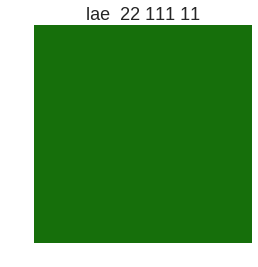

Epoch: 2 and Temperature: 0.5
ldo aepay 20 22 2212


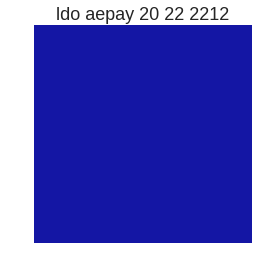

Epoch: 2 and Temperature: 1
lsf2  542 003
unable to parse color


Epoch 1/1
14157/14157 [==============================] - 88s 6ms/step - loss: 1.2589
Epoch: 3 and Temperature: 0.2
leee bire 149 110 113


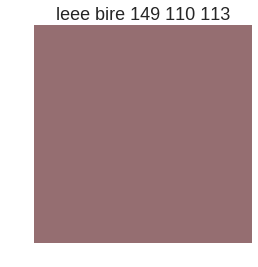

Epoch: 3 and Temperature: 0.5
lnit 118 86 186


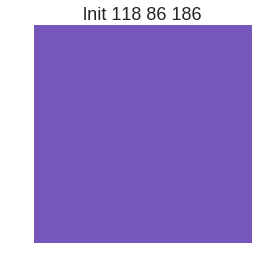

Epoch: 3 and Temperature: 1
lare goir huln 70 24 
unable to parse color


Epoch 1/1
14157/14157 [==============================] - 89s 6ms/step - loss: 1.1919
Epoch: 4 and Temperature: 0.2
loite tee 213 111 13


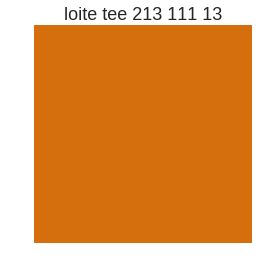

Epoch: 4 and Temperature: 0.5
lee paen 210 212 105


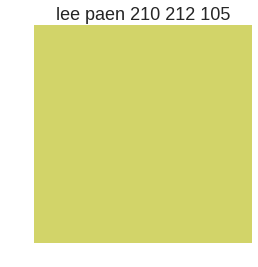

Epoch: 4 and Temperature: 1
llktotuo 183 41 95


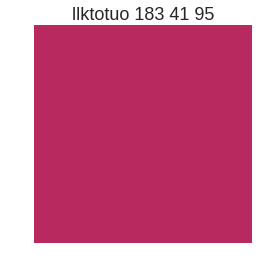



Epoch 1/1
14157/14157 [==============================] - 89s 6ms/step - loss: 1.1467
Epoch: 5 and Temperature: 0.2
linte 245 221 220


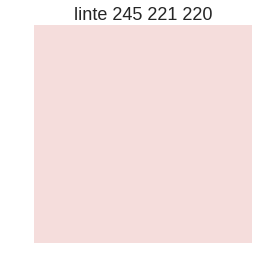

Epoch: 5 and Temperature: 0.5
lue silin 23 222 204


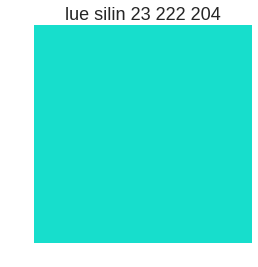

Epoch: 5 and Temperature: 1
luh soele 99 163 14


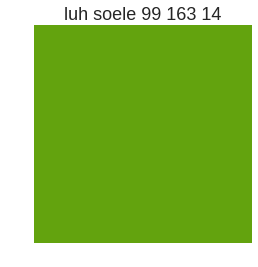



Epoch 1/1
14157/14157 [==============================] - 89s 6ms/step - loss: 1.1085
Epoch: 6 and Temperature: 0.2
lean beren 154 110 16


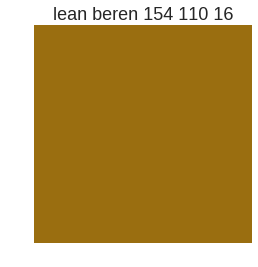

Epoch: 6 and Temperature: 0.5
lannite brua 87 119 1


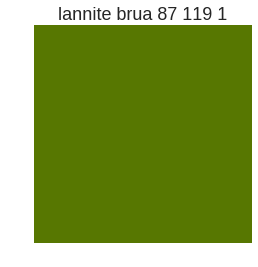

Epoch: 6 and Temperature: 1
lity igluan 165 190 1


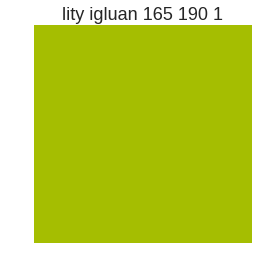



Epoch 1/1
14157/14157 [==============================] - 88s 6ms/step - loss: 1.0829
Epoch: 7 and Temperature: 0.2
lante mant 255 220 21


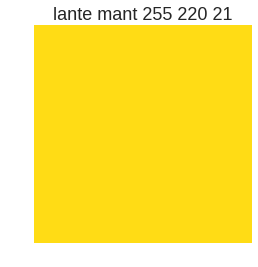

Epoch: 7 and Temperature: 0.5
lole sige 225 243 205


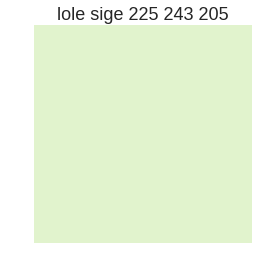

Epoch: 7 and Temperature: 1
leranser gany 192 111
unable to parse color


Epoch 1/1
14157/14157 [==============================] - 88s 6ms/step - loss: 1.0635
Epoch: 8 and Temperature: 0.2
lone green 138 116 16


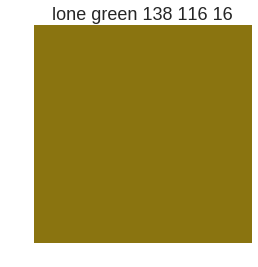

Epoch: 8 and Temperature: 0.5
leran bare 155 186 15


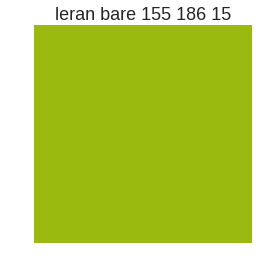

Epoch: 8 and Temperature: 1
litk rhite 278 93 72


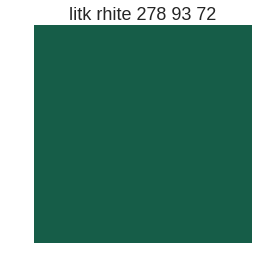



Epoch 1/1
14157/14157 [==============================] - 88s 6ms/step - loss: 1.0460
Epoch: 9 and Temperature: 0.2
lere green 114 116 11


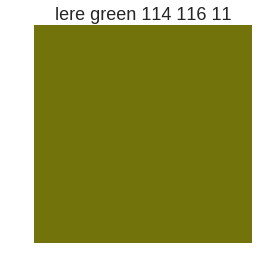

Epoch: 9 and Temperature: 0.5
loop ping 221 212 171


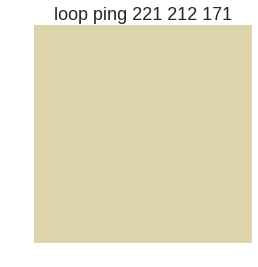

Epoch: 9 and Temperature: 1
lagf plue 105 160 227


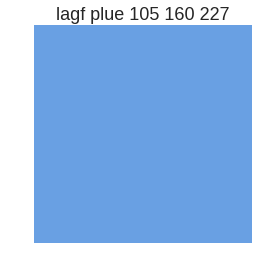



Epoch 1/1
14157/14157 [==============================] - 88s 6ms/step - loss: 1.0309
Epoch: 10 and Temperature: 0.2
lich green 121 136 13


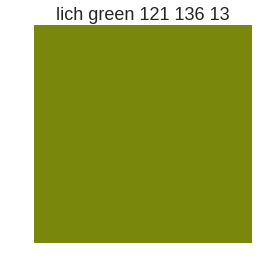

Epoch: 10 and Temperature: 0.5
lavere groe 10 80 86


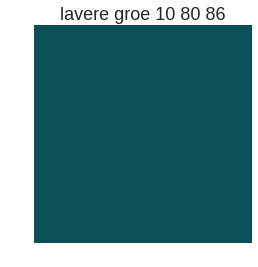

Epoch: 10 and Temperature: 1
lapeniw sweele 169 19
unable to parse color


In [79]:
## Update such that the generate text function can take in a start string and then compare with the outputs that pass in only a single char
BATCH_SIZE = 32
nb_epoch = 0
while nb_epoch<10:
    print('\n')
    model.fit(onehot_inp, onehot_tar, batch_size=BATCH_SIZE, verbose=1, epochs=1)
    nb_epoch += 1
    for temperature in [0.2,0.5,1]:
      print('Epoch:', nb_epoch, 'and Temperature:', temperature)
      generate_text_and_plot(model, length=20, temperature=temperature)

### As we can see from above, lower temperatures (0.2 and 0.5) produce better color names (by observation)

## Generating some color names and plotting them

lean green 180 144 10


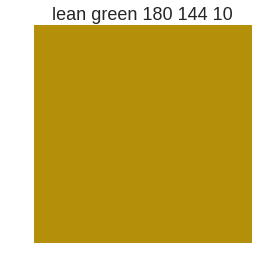

In [81]:
generate_text_and_plot(model, length=20, start_char='l', temperature=0.2)

lager lowe 132 116 11


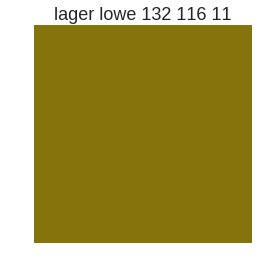

In [83]:
generate_text_and_plot(model, length=20, start_char='l', temperature=0.5)

ranger blue 10 10 12


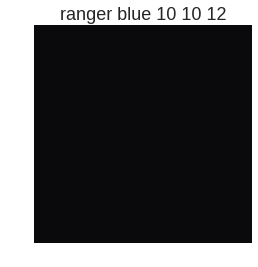

In [88]:
generate_text_and_plot(model, length=20, start_char='r', temperature=0.2)

rose green 137 160 13


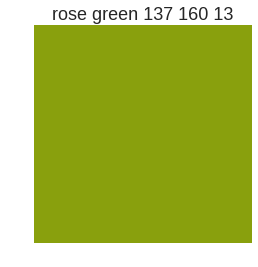

In [90]:
generate_text_and_plot(model, length=20, start_char='r', temperature=0.5)